In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image
import random
from sklearn.metrics import classification_report

In [2]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Task 1: Data Understanding and Visualization

In [3]:


# Define paths (replace the URL with your dataset location in Google Drive)
dataset_url = '/content/drive/MyDrive/AIML/Workshop_5/FruitinAmazon'  # Replace with your actual path in Google Drive
base_dir = dataset_url
train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'test')

Task 1: Visualizing samples


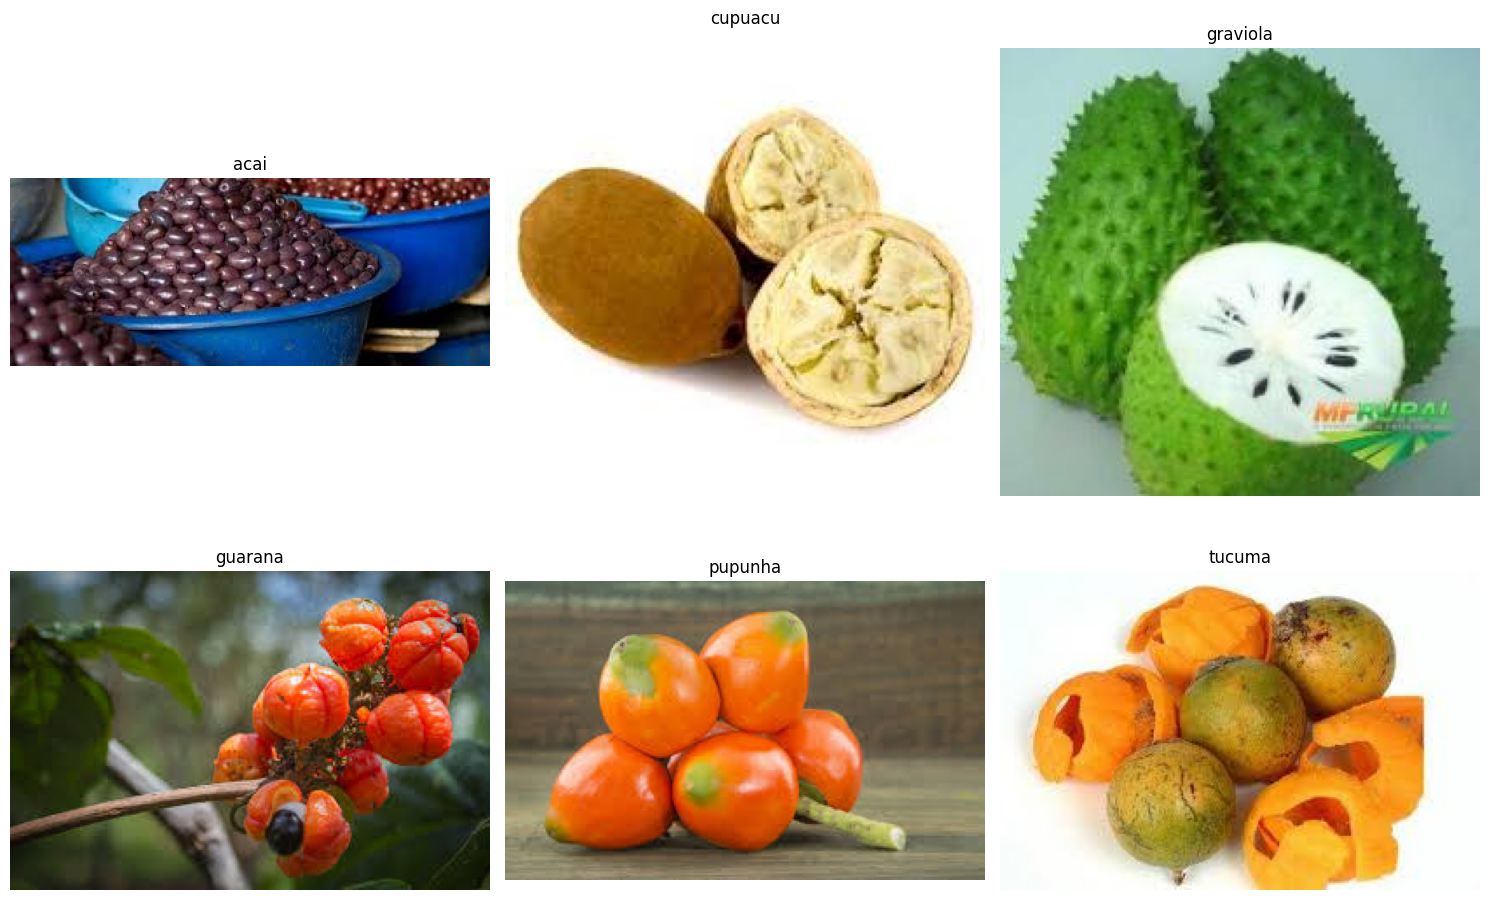

In [4]:
# Task 1: Data Understanding and Visualization
def visualize_samples():
    # Get only directories (ignore files like .DS_Store)
    class_names = [d for d in os.listdir(train_dir) if os.path.isdir(os.path.join(train_dir, d))]
    class_names = sorted(class_names)

    if len(class_names) < 6:
        print(f"Warning: Found only {len(class_names)} classes, expected 6.")

    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.ravel()

    for idx, class_name in enumerate(class_names[:6]):  # Limit to 6 classes for 2x3 grid
        class_path = os.path.join(train_dir, class_name)
        image_files = os.listdir(class_path)
        if not image_files:
            print(f"No images found in {class_path}")
            continue

        random_image = random.choice(image_files)
        image_path = os.path.join(class_path, random_image)

        try:
            img = Image.open(image_path)
            axes[idx].imshow(img)
            axes[idx].set_title(class_name)
            axes[idx].axis('off')
        except Exception as e:
            print(f"Error loading image {image_path}: {e}")

    plt.tight_layout()
    plt.show()

print("Task 1: Visualizing samples")
visualize_samples()

In [5]:
# Check for corrupted images
def check_corrupted_images():
    corrupted_images = []
    # Get only directories (ignore files like .DS_Store)
    class_names = [d for d in os.listdir(train_dir) if os.path.isdir(os.path.join(train_dir, d))]

    for class_name in class_names:
        class_path = os.path.join(train_dir, class_name)
        for image_file in os.listdir(class_path):
            image_path = os.path.join(class_path, image_file)
            try:
                img = Image.open(image_path)
                img.verify()
            except (IOError, SyntaxError) as e:
                corrupted_images.append(image_path)
                os.remove(image_path)
                print(f"Removed corrupted image: {image_path}")

    if not corrupted_images:
        print("No corrupted images found.")

print("\nTask 1: Checking for corrupted images")
check_corrupted_images()


Task 1: Checking for corrupted images
No corrupted images found.


## Task 2: Loading and Preprocessing Image Data in Keras

In [12]:
# Task 2: Load and Preprocess Data
img_height = 128
img_width = 128
batch_size = 16
validation_split = 0.2

# Create preprocessing layer
rescale = tf.keras.layers.Rescaling(1./255)

# Define data augmentation layer
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
])

# Load training dataset
train_ds_raw = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    labels='inferred',
    label_mode='int',
    image_size=(img_height, img_width),
    interpolation='nearest',
    batch_size=batch_size,
    shuffle=True,
    validation_split=validation_split,
    subset='training',
    seed=123
)

# Load validation dataset
val_ds_raw = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    labels='inferred',
    label_mode='int',
    image_size=(img_height, img_width),
    interpolation='nearest',
    batch_size=batch_size,
    shuffle=False,
    validation_split=validation_split,
    subset='validation',
    seed=123
)

# Load test dataset
test_ds_raw = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    labels='inferred',
    label_mode='int',
    image_size=(img_height, img_width),
    interpolation='nearest',
    batch_size=batch_size,
    shuffle=False
)

# Get class names from the raw training dataset
class_names = train_ds_raw.class_names
num_classes = len(class_names)

# Apply augmentation and normalization to training data only
train_ds = train_ds_raw.map(lambda x, y: (data_augmentation(x, training=True), y))
train_ds = train_ds.map(lambda x, y: (rescale(x), y))

# Apply normalization to validation and test data
val_ds = val_ds_raw.map(lambda x, y: (rescale(x), y))
test_ds = test_ds_raw.map(lambda x, y: (rescale(x), y))

Found 90 files belonging to 6 classes.
Using 72 files for training.
Found 90 files belonging to 6 classes.
Using 18 files for validation.
Found 30 files belonging to 6 classes.


## Task 3: Implement a CNN

In [17]:
# Task 3: Build CNN Model
def create_model():
    model = models.Sequential([
        # Convolutional Layer 1
        layers.Conv2D(32, (3, 3), padding='same', strides=1, activation='relu',
                     input_shape=(img_height, img_width, 3)),
        layers.MaxPooling2D((2, 2), strides=2),

        # Convolutional Layer 2
        layers.Conv2D(32, (3, 3), padding='same', strides=1, activation='relu'),
        layers.MaxPooling2D((2, 2), strides=2),

        # Fully Connected Layers
        layers.Flatten(),
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.5),  # Added dropout to reduce overfitting
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),  # Added dropout to reduce overfitting
        layers.Dense(num_classes, activation='softmax')
    ])
    return model

model = create_model()
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)                    │ (None, 128, 128, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 64, 64, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 32768)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 64)                  │       2,097,216 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 128)                 │           8,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 6)                   │             774 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,116,454 (8.07 MB)

 Trainable params: 2,116,454 (8.07 MB)

 Non-trainable params: 0 (0.00 B)

## Task 4: Compile and Train the Model

Epoch 1/250
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 398ms/step - accuracy: 0.1785 - loss: 1.7993 - val_accuracy: 0.3889 - val_loss: 1.7381
Epoch 2/250
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 556ms/step - accuracy: 0.3380 - loss: 1.7832 - val_accuracy: 0.5556 - val_loss: 1.6826
Epoch 3/250
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 463ms/step - accuracy: 0.2216 - loss: 1.8523 - val_accuracy: 0.1111 - val_loss: 1.7223
Epoch 4/250
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 349ms/step - accuracy: 0.1183 - loss: 1.8550 - val_accuracy: 0.0000e+00 - val_loss: 1.7801
Epoch 5/250
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 321ms/step - accuracy: 0.1256 - loss: 1.8266 - val_accuracy: 0.0000e+00 - val_loss: 1.7778
Epoch 6/250
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 355ms/step - accuracy: 0.2555 - loss: 1.7488 - val_accuracy: 0.3333 - val_loss: 1.7139
Epoch 7/250
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 379ms/step - accuracy: 0.1814 - loss: 1.8021 - val_accuracy: 0.6111 - val_loss: 1.7182
Epoch 8/250
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 570ms/step - accuracy: 0.1962 - loss: 1.8193 - val_accuracy: 0.

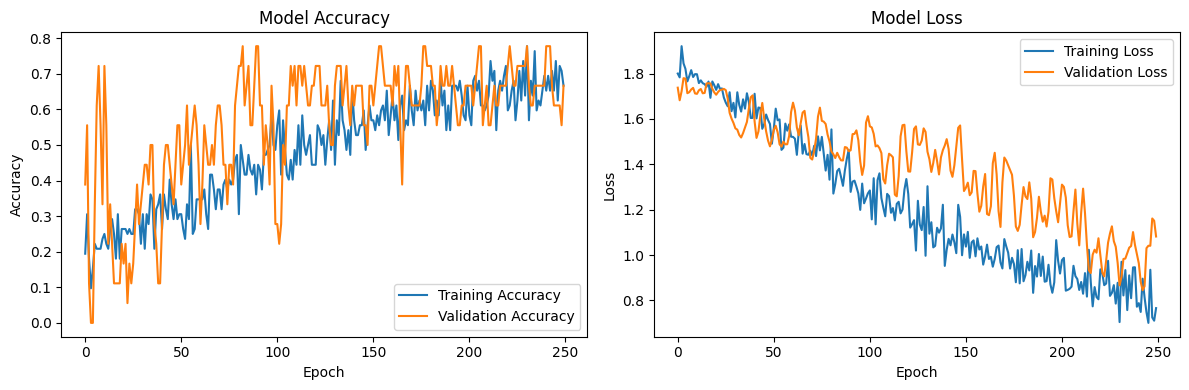

In [14]:
# Task 4: Compile and Train the Model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),  # Lower learning rate
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Define callbacks
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    'best_model.keras',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max'
)

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=50,  # Increased patience to allow more training
    restore_best_weights=True
)

# Train the model
history = model.fit(
    train_ds,
    epochs=250,
    validation_data=val_ds,
    callbacks=[checkpoint, early_stopping]
)

# Visualize training results
def plot_training_history(history):
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

print("\nTask 3-4: Training model")
plot_training_history(history)

## Task 5: Evaluate the Model

In [9]:
# Task 5: Evaluate the Model
test_loss, test_accuracy = model.evaluate(test_ds)
print(f"Test accuracy: {test_accuracy:.4f}")
print(f"Test loss: {test_loss:.4f}")

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - accuracy: 0.6292 - loss: 1.0017
Test accuracy: 0.6000
Test loss: 1.1412


## Task 6: Save and Load the Model

In [15]:
# Task 6: Save and Load the Model
model.save('fruit_classifier.h5')

# Load and re-evaluate
loaded_model = tf.keras.models.load_model('fruit_classifier.h5')
loaded_test_loss, loaded_test_accuracy = loaded_model.evaluate(test_ds)
print(f"Loaded model test accuracy: {loaded_test_accuracy:.4f}")

# Save to Google Drive
!cp fruit_classifier.h5 /content/drive/MyDrive/AIML/Workshop_5/fruit_classifier.h5

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step - accuracy: 0.7806 - loss: 0.6886
Loaded model test accuracy: 0.7333


## Task 7: Predictions and Classification Report

In [16]:
# Task 7: Make Predictions and Generate Classification Report
test_images = []
test_labels = []
for images, labels in test_ds.unbatch():
    test_images.append(images.numpy())
    test_labels.append(labels.numpy())

test_images = np.array(test_images)
test_labels = np.array(test_labels)

predictions = loaded_model.predict(test_images)
predicted_labels = np.argmax(predictions, axis=1)

# Generate classification report
print("\nClassification Report:")
print(classification_report(test_labels, predicted_labels, target_names=class_names))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 371ms/step

Classification Report:
              precision    recall  f1-score   support

        acai       0.50      1.00      0.67         5
     cupuacu       0.80      0.80      0.80         5
    graviola       1.00      0.80      0.89         5
     guarana       0.67      0.80      0.73         5
     pupunha       1.00      0.60      0.75         5
      tucuma       1.00      0.40      0.57         5

    accuracy                           0.73        30
   macro avg       0.83      0.73      0.73        30
weighted avg       0.83      0.73      0.73        30

